<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/S11-Assignment/')
!ls /content/gdrive/My\ Drive/S11-Assignment

dataloader.py	    grad_cam.py       Models	       S10-graph.png
Data_Transforms     __init__.py       one_cycle.py     S10.ipynb
data_transforms.py  lr_finder.py      README.md        utils.py
eval.py		    misclassified.py  S10-GradCam.pdf


In [0]:
%cd /content/gdrive/My Drive/S11-Assignment/

/content/gdrive/My Drive/S11-Assignment


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
!pip install albumentations

     |████████████████████████████████| 634kB 6.9MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=3e173079966ee50190a300cfd3eb74972d0ba1956a84cce6d30f1e25964fe9d8
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
cd /content/gdrive/My Drive/S11-Assignment/

/content/gdrive/My Drive/S11-Assignment


In [0]:
from Data_Transforms import transform

import importlib
importlib.reload(transform)

#from transform  import Data
data = transform.Data()

trainset = data.getTrainDataSetTorchTransforms(train=True)
testset =  data.getTestDataSetTorchTransforms(train=False)
trainloader = data.getDataLoader(trainset, 512)
show_trainloader = data.getDataLoader(trainset, 4)
testloader = data.getDataLoader(testset, 512)
show_testloader = data.getDataLoader(testset, 4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


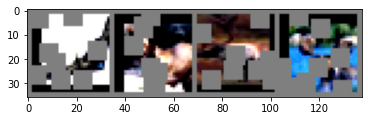

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import utils

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
utils.imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:

import torch
from Models import customresnet
!pip install torchsummary
from torchsummary import summary

model = customresnet.CustomResNet()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


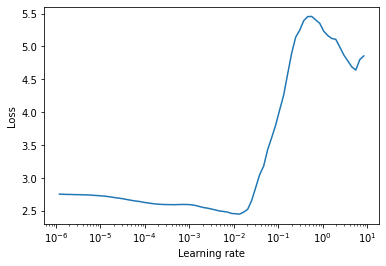

In [0]:
from lr_finder import LRFinder

import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import StepLR


EPOCHS = 24
l2_loss = 0.0001
l1_lambda = 0
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=l2_loss)

#LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.
We'll plot loss vs learning rate plot.
We'll then select learning rate that is one power higher than the one where loss is minimum
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate
can be set to 1/3, 1/4th of max value.



In [0]:
#Find the min loss from lr finder
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(min(loss))
print(lr[loss.index(min(loss))])


2.449845111139586
0.013489628825916521


In [0]:
LRMAX = 0.1
LRMIN = 0.01

In [0]:
import one_cycle as OneCycle
from torch.optim.lr_scheduler import ReduceLROnPlateau

onecycle = OneCycle.OneCycle(int(len(trainset) * EPOCHS / 512), LRMAX, prcnt=60, momentum_vals=(0.95, 0.8))

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=l2_loss)

# ReduceLROnPlateau
#schedular = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 4)
schedular = None
model.evaluate(optimizer, trainloader, testloader, EPOCHS, criterion, onecycle, schedular, False, l1_lambda)

Epoch= 0 Loss=2.909911870956421 Batch_id=97 Accuracy=15.48: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0, Train Accuracy: 15.476190476190476 , Test Accuracy: 22.46


Epoch= 1 Loss=1.8366258144378662 Batch_id=97 Accuracy=31.55: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1, Train Accuracy: 31.547619047619047 , Test Accuracy: 27.29


Epoch= 2 Loss=1.6067297458648682 Batch_id=97 Accuracy=45.83: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2, Train Accuracy: 45.833333333333336 , Test Accuracy: 43.43


Epoch= 3 Loss=1.544122576713562 Batch_id=97 Accuracy=51.19: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3, Train Accuracy: 51.19047619047619 , Test Accuracy: 47.84


Epoch= 4 Loss=1.1969016790390015 Batch_id=97 Accuracy=62.50: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4, Train Accuracy: 62.5 , Test Accuracy: 57.62


Epoch= 5 Loss=1.2807197570800781 Batch_id=97 Accuracy=59.23: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5, Train Accuracy: 59.226190476190474 , Test Accuracy: 61.18


Epoch= 6 Loss=1.0497421026229858 Batch_id=97 Accuracy=67.26: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6, Train Accuracy: 67.26190476190476 , Test Accuracy: 65.1


Epoch= 7 Loss=0.8989750146865845 Batch_id=97 Accuracy=70.54: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7, Train Accuracy: 70.53571428571429 , Test Accuracy: 70.14


Epoch= 8 Loss=0.9061509966850281 Batch_id=97 Accuracy=71.73: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8, Train Accuracy: 71.72619047619048 , Test Accuracy: 73.2


Epoch= 9 Loss=0.8810811042785645 Batch_id=97 Accuracy=72.02: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9, Train Accuracy: 72.02380952380952 , Test Accuracy: 76.4


Epoch= 10 Loss=0.7593160271644592 Batch_id=97 Accuracy=74.11: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10, Train Accuracy: 74.10714285714286 , Test Accuracy: 77.88


Epoch= 11 Loss=0.7967777252197266 Batch_id=97 Accuracy=72.92: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11, Train Accuracy: 72.91666666666667 , Test Accuracy: 79.21


Epoch= 12 Loss=0.6621659398078918 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12, Train Accuracy: 79.16666666666667 , Test Accuracy: 79.54


Epoch= 13 Loss=0.7639997601509094 Batch_id=97 Accuracy=74.40: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13, Train Accuracy: 74.4047619047619 , Test Accuracy: 80.37


Epoch= 14 Loss=0.6512982845306396 Batch_id=97 Accuracy=76.79: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14, Train Accuracy: 76.78571428571429 , Test Accuracy: 80.5


Epoch= 15 Loss=0.6449213027954102 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15, Train Accuracy: 76.48809523809524 , Test Accuracy: 81.82


Epoch= 16 Loss=0.6060274839401245 Batch_id=97 Accuracy=80.95: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16, Train Accuracy: 80.95238095238095 , Test Accuracy: 82.29


Epoch= 17 Loss=0.5631033778190613 Batch_id=97 Accuracy=83.63: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17, Train Accuracy: 83.63095238095238 , Test Accuracy: 83.22


Epoch= 18 Loss=0.6797090768814087 Batch_id=97 Accuracy=75.89: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18, Train Accuracy: 75.89285714285714 , Test Accuracy: 83.27


Epoch= 19 Loss=0.5765402913093567 Batch_id=97 Accuracy=80.95: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19, Train Accuracy: 80.95238095238095 , Test Accuracy: 83.15


Epoch= 20 Loss=0.6340850591659546 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20, Train Accuracy: 76.48809523809524 , Test Accuracy: 83.62


Epoch= 21 Loss=0.6134494543075562 Batch_id=97 Accuracy=79.46: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21, Train Accuracy: 79.46428571428571 , Test Accuracy: 84.14


Epoch= 22 Loss=0.5541070103645325 Batch_id=97 Accuracy=81.25: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22, Train Accuracy: 81.25 , Test Accuracy: 84.05


Epoch= 23 Loss=0.6116999983787537 Batch_id=97 Accuracy=81.25: 100%|██████████| 98/98 [02:03<00:00,  1.26s/it]
100%|██████████| 20/20 [00:04<00:00,  4.08it/s]

Epoch 23, Train Accuracy: 81.25 , Test Accuracy: 83.09


In [0]:
print(int(len(trainset) * EPOCHS / 512))

2343


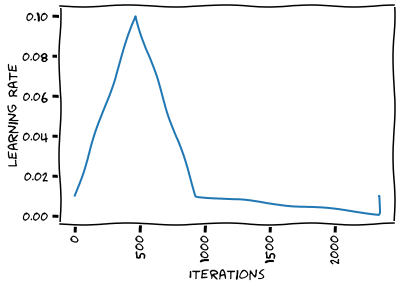

In [0]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=500), rotation=90)
plt.plot(onecycle.lrs[:2343])
plt.savefig('onecycle_lr.jpg')